# Vector Sequence

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/yggdrasil-decision-forests/blob/main/documentation/public/docs/tutorial/numerical_vector_sequence.ipynb)

## Setup


In [ ]:
pip install ydf transformers torch jax tqdm datasets scikit-learn matplotlib -U

In [3]:
from itertools import islice

from datasets import load_dataset # The text dataset
import matplotlib.pyplot as plt # For plotting the toy dataset
import numpy as np
from sklearn.decomposition import PCA # PCA is used to reduce the embedding dimension
from sklearn.preprocessing import StandardScaler
import torch
from tqdm import tqdm # For the progress-bar
from transformers import GPT2Model, GPT2Tokenizer # To compute some embeddings
import ydf

## What are Vector Sequence features?

**Vector sequence features** are a type of input feature where each value is a sequence (or list) of multi-dimensional, fixed-size numerical vectors.  They are well-suited for encoding sets or time series of embeddings, such as embeddings of a collection of images or the embeddings of intermediate layers within a Large Language Model (LLM).

They can be seen as an extension of multi-dimensional numerical features, as illustrated below

| Type                           | Example of value            |
|--------------------------------|-----------------------------|
| (Single dimensional) numerical | 4.3                         |
| Multi-dimensional numerical    | [1,5,2]                     |
| Vector sequence numerical     | [[1,2,3], [4,5,6], [7,8,9]] |

While the number of vectors within different vector sequence values can vary, all vectors within a given sequence must have the same dimensionality (shape).


## About this tutorial

This tutorial is divided into two parts. The first part shows how to create sequence features on simple toy data.

The second part shows a more complex example that combines LLM embedding, PCA and vector sequences: We'll use the first hidden layer of the GPT2 model, apply a PCA to reduce its dimensionality (this is an optional step to make the training faster), and use is as a vector sequence feature for text classification with a decision forest.

## Part 1: Vector sequence on a simple toy example

For in-memory datasets, vector sequences are represented as **Python lists of NumPy arrays**, where each array has the shape <vector index, vector dimension>.

**Note:**

- Pandas DataFrames don't work well with multi-dimensional values. A simple Python dictionary of values is simpler and more efficient.
- For file-based datasets, a format capable of representing two-dimensional values is needed.  Currently, Avro is the only natively supported format for this.

Our toy dataset is simple: Each feature value is a list of 2D points (between 0 and 5). A sample is labeled "true" if at least one of its points is within the unit circle (centered at (0,0) with a radius of 1), and "false" otherwise. Around 50% of the examples will be positives. Let's build this dataset.

In [4]:
def make_toy_ds(num_examples=1_000):
  features = []
  labels = []
  for _ in range(num_examples):
    num_vectors = np.random.randint(0, 5)
    vectors = np.random.uniform(-1.5, 1.5, [num_vectors, 2])
    label = np.any(np.sum(vectors**2, axis=1) < 1)
    features.append(vectors)
    labels.append(label)
  return {"label": np.array(labels), "feature": features}


# Generate 3 examples
make_toy_ds(num_examples=3)

{'label': array([False, False,  True]),
 'feature': [array([[ 0.47221051, -1.04686068],
         [ 1.40348894, -1.00676166],
         [ 0.63440287,  1.29930153],
         [-1.28285904, -1.44044944]]),
  array([[-1.44968141,  1.18143043],
         [-1.35090648,  1.05524487],
         [-0.47623758,  1.02229518]]),
  array([[-0.73034892, -1.03253695],
         [ 0.47363613, -0.61725529],
         [-0.02912192, -1.47682402]])]}

Let's plot some examples to make sure the pattern is there.

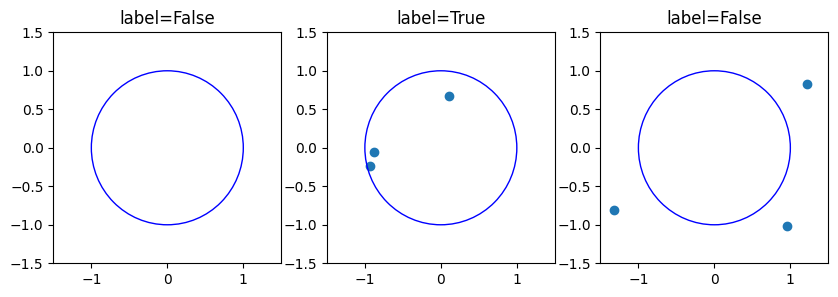

In [5]:
num_examples = 3
dataset = make_toy_ds(num_examples)
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
for example_idx, ax in enumerate(axs):
  feature = dataset["feature"][example_idx]
  ax.scatter([v[0] for v in feature], [v[1] for v in feature])
  ax.set_title(f"label={dataset['label'][example_idx]}")
  ax.set_xlim(-1.5, 1.5)
  ax.set_ylim(-1.5, 1.5)
  # Show the circle
  ax.add_artist(
      plt.Circle((0, 0), 1, edgecolor="blue", facecolor="none", linewidth=1)
  )

Then, we can train our model.

In [6]:
train_ds = make_toy_ds(num_examples=10_000)
model = ydf.RandomForestLearner(label="label").train(train_ds)

Train model on 10000 examples
Model trained in 0:00:05.606750


The following cell shows the model's description. In the **Dataspec**" tab, you can see the feature statistics (e.g., distribution of the number of vectors, vector dimension). In the **Structure** tab, you can see the tree conditions that are learned.

For example, the condition `"feature" contains X with | X - [0.054303, -0.062462] |² <= 0.996597` evaluates to true iff there is a vector at a distance of less than 0.996 from (0.054303, -0.0624). This is very close to the rule we used to generated the dataset: a distance of less than 1. from (0., 0.).

In [7]:
model.describe()

Finally, we can evaluate the model.

In [8]:
test_ds = make_toy_ds(num_examples=1000)
model.evaluate(test_ds)

Label \ Pred,false,true
false,492,5
true,1,502


## Part 2: LLM embedding + PCA + Vector Sequence

Now that we understand vector sequences, let's build a text classifier using GPT2's first hidden layer and a Random Forest.

Our model pipeline:

1. **GPT2 Tokenizer:** Converts text to tokens e.g., "the cat is red" → [362, 82, 673, 6543].
1. **GPT2 Token Embedding:** Grabs the embedding of each token. Output shape: <num tokens, 768>.
1. **GPT2 First Hidden Layer:** Applies the first layer of GPT2 (Attention and other NN operations). Output shape: <num tokens, 768>.
1. **PCA:** Reduces dimensionality of the embedding. Output shape: <num tokens, 100>.
1. **Random Forest:** Train a Random Forest to classify text from the PCA-transformed embeddings.


### GPT2 model
We load GPT2 tokenizer and weights.

In [9]:
gpt2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
gpt2_model = GPT2Model.from_pretrained("gpt2", output_hidden_states=True)

The tokenizer encodes a text into a list of token indexes.

In [10]:
tokens = gpt2_tokenizer("This is a good movie", return_tensors="pt")
print(tokens["input_ids"])

tensor([[1212,  318,  257,  922, 3807]])


Then, we apply the GPT2 model on the tokens and extract the output of layer #0. This computes the token embeddings and apply one layer of attention.

In [11]:
selected_hidden_layer = 0
gpt2_model(**tokens).hidden_states[selected_hidden_layer]

tensor([[[ 0.0065, -0.2930,  0.0762,  ...,  0.0184, -0.0275,  0.1638],
         [ 0.0142, -0.0437, -0.0393,  ...,  0.1487, -0.0278, -0.0255],
         [-0.0464, -0.0791,  0.1016,  ...,  0.0623,  0.0928, -0.0598],
         [-0.0841, -0.1244,  0.1423,  ..., -0.1435, -0.0718, -0.1183],
         [ 0.0331, -0.0645,  0.3507,  ..., -0.0210,  0.0279,  0.1440]]],
       grad_fn=<AddBackward0>)

Let's group those two steps in a function that returns a numpy array.

In [12]:
def text_to_embedding(text: str) -> np.ndarray:
  tokens = gpt2_tokenizer(text, return_tensors="pt")
  return (
      gpt2_model(**tokens)
      .hidden_states[selected_hidden_layer]
      .detach()
      .numpy()[0]
  )


text_to_embedding("This is a good movie")

array([[ 0.00649832, -0.29302013,  0.07615747, ...,  0.01843522,
        -0.02754061,  0.16376127],
       [ 0.01423593, -0.0437407 , -0.0392998 , ...,  0.14866675,
        -0.02783391, -0.02553328],
       [-0.04641282, -0.07912885,  0.10156769, ...,  0.06225622,
         0.09284618, -0.05983091],
       [-0.08413801, -0.12438498,  0.14228812, ..., -0.14347112,
        -0.07182924, -0.1183255 ],
       [ 0.03311015, -0.06451828,  0.35070336, ..., -0.02101075,
         0.0278743 ,  0.14398581]], dtype=float32)

### Load the dataset

AG News is a text classification dataset, where the task is to predict an article's category based on its content. Let's load it.

In [13]:
def ag_news_dataset(split: str):
  class_mapping = {
      0: "World",
      1: "Sports",
      2: "Business",
      3: "Sci/Tech",
  }
  for example in load_dataset("ag_news")[split]:
    yield {
        "text": example["text"],
        "label": class_mapping[example["label"]],
    }


# Print the first 3 training examples
for example_idx, example in enumerate(islice(ag_news_dataset("train"), 3)):
  print(f"==========\nExample #{example_idx}\n----------")
  print(example)

Example #0
----------
{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.", 'label': 'Business'}
Example #1
----------
{'text': 'Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\\which has a reputation for making well-timed and occasionally\\controversial plays in the defense industry, has quietly placed\\its bets on another part of the market.', 'label': 'Business'}
Example #2
----------
{'text': "Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\\about the economy and the outlook for earnings are expected to\\hang over the stock market next week during the depth of the\\summer doldrums.", 'label': 'Business'}


We load more of the dataset.

In [14]:
num_examples = 1000  # Only load 1k example for the example.
labels = []
embeddings = []
for example in tqdm(
    islice(ag_news_dataset("train"), num_examples), total=num_examples
):
  embeddings.append(text_to_embedding(example["text"]))
  labels.append(example["label"])
# raw_dataset = {"label": np.array(labels), "embedding": embeddings}

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:41<00:00, 24.00it/s]


Each example has a different number of tokens i.e. a different shape for the embedding matrix.

In [15]:
print("First example embedding size:", embeddings[0].shape)
print("Second example embedding size:", embeddings[1].shape)

First example embedding size: (37, 768)
Second example embedding size: (55, 768)


### Compress the embedding
Our dataset is small, so we can speed up training by using PCA to reduce the 768-dimensional embeddings to 50 dimensions without losing much accuracy. Let's do that.

In [16]:
# Collect all the embeddings into a single matrix.
combined_embeddings = np.concatenate(embeddings, axis=0)
# Normalize the embedding (this is necessary for PCA).
normalized_combined_embeddings = StandardScaler().fit_transform(
    combined_embeddings
)
# Learn the compressed representation.
pca = PCA(n_components=50)
_ = pca.fit(normalized_combined_embeddings)

We compress our actual embedding values.

In [17]:
reduced_embeddings = [pca.transform(e) for e in embeddings]

In [18]:
print("First example embedding size:", reduced_embeddings[0].shape)
print("Second example embedding size:", reduced_embeddings[1].shape)

First example embedding size: (37, 50)
Second example embedding size: (55, 50)


Finally, we assemble the data into a dictionary.

In [19]:
dataset = {"label": np.array(labels), "reduced_embeddings": reduced_embeddings}

### Train model

We can now train our model.

In [20]:
model = ydf.RandomForestLearner(label="label").train(dataset, verbose=2)

Train model on 1000 examples
Model trained in 0:00:49.579565


Since the model is a Random Forest, we can look at the model self-evaluation (a.k.a., Out-of-bag evaluation) to estimate the model quality.

In [21]:
model.self_evaluation()

Label \ Pred,Business,Sci/Tech,Sports,World
Business,81,4,0,4
Sci/Tech,87,461,36,43
Sports,0,0,100,5
World,6,7,6,160
